# Morse Decoder

Decode (international) morse code signals to text

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import butter, lfilter, find_peaks
from scipy.fft import fft, fftfreq

# international morse code lookup
# https://en.wikipedia.org/wiki/American_Morse_code#Comparison_of_American_and_International_Morse
MORSE_DICT = {
    # letters
    'A': '.-',   'B': '-...', 'C': '-.-.', 'D': '-..',  'E': '.',
    'F': '..-.', 'G': '--.',  'H': '....', 'I': '..',   'J': '.---',
    'K': '-.-',  'L': '.-..', 'M': '--',   'N': '-.',   'O': '---',
    'P': '.--.', 'Q': '--.-', 'R': '.-.',  'S': '...',  'T': '-',
    'U': '..-',  'V': '...-', 'W': '.--',  'X': '-..-', 'Y': '-.--',
    'Z': '--..',
    # digits
    '0': '-----', '1': '.----', '2': '..---', '3': '...--', '4': '....-', 
    '5': '.....', '6': '-....', '7': '--...', '8': '---..', '9': '----.',
    # punctuation
    '.': '.-.-.-', ', ': '--..--', '?': '..--..',  '!': '-.-.--',
    ';': '-.-.-.', ':': '---...',  '\'': '.----.', '/': '-..-.',
    '-': '-....-', '(': '-.--.',   ')': '-.--.-'
}
MORSE_DICT_REV = {v: k for k,v in MORSE_DICT.items()}


In [83]:
def gen_morse_wav(txt, out_path, wpm = 20, freq = 700, sample_rate = 44100):
    """
    Generate WAV file of morse code of given string.
    """

    # timing units using 50 dit duration standard word PARIS -> T = 1200ms/wpm
    dit_units = 1.2 / wpm
    dah_units = 3 * dit_units
    symbol_units = dit_units
    letter_units = 3 * dit_units
    word_units = 7 * dit_units

    def tone(duration):
        t = np.linspace(0.0, duration, int(sample_rate * duration), endpoint=False)
        return 0.5 * np.sin(2 * np.pi * freq * t)

    def silence(duration):
        return np.zeros(int(sample_rate * duration))
    
    dit_tone = tone(dit_units)
    dah_tone = tone(dah_units)
    symbol_gap = silence(symbol_units)
    letter_gap = silence(letter_units)
    word_gap = silence(word_units)

    # build signal
    morse_signal = np.array([], dtype=np.float32)
    for i, c in enumerate(txt.upper()):
        if c == ' ':
            morse_signal = np.concatenate([morse_signal, word_gap])
        elif c in MORSE_DICT:
            morse = MORSE_DICT[c]

            for j, symbol in enumerate(morse):
                morse_signal = np.concatenate([morse_signal, dit_tone if symbol == '.' else dah_tone])

                # add gap between symbols of a letter
                if j < len(morse) - 1:
                    morse_signal = np.concatenate([morse_signal, symbol_gap])

            # add gap between letters
            if i < len(txt) - 1 and txt[i + 1] != ' ':
                morse_signal = np.concatenate([morse_signal, letter_gap])
        else:
            raise Exception(f'Cannot convert {c} to morse code')
    
    # 32767 scales signal for 16-bit WAV file
    wavfile.write(out_path, sample_rate, (morse_signal * 32767).astype(np.int16))

    return sample_rate, morse_signal


In [ ]:
def find_peak_frequency(signal, sample_rate):
    """
    Find peak frequency of signal using Fast Fourier Transform.
    """
    N = len(signal)
    if N == 0:
        return None, None, None
    
    yf = fft(signal)
    xf = fftfreq(N, 1 / sample_rate)

    # only care about positive frequencies. FFT result symmetric so negative frequencies are mirrored
    xf_pos = xf[:N//2]
    yf_pos = np.abs(yf[:N//2])

    # find index of peak magnitude. Typical morse range > 400Hz
    try:
        min_freq_idx = np.where(xf_pos > 400)[0][0]
        peak_freq_idx = min_freq_idx + np.argmax(yf_pos[min_freq_idx:])
        peak_freq = xf_pos[peak_freq_idx]
        return peak_freq, xf_pos, yf_pos
    except IndexError:
        peak_freq_idx = np.argmax(yf_pos)
        peak_freq = xf_pos[peak_freq_idx]
        return peak_freq, xf_pos, yf_pos

def bandpass_filter(signal, low_threshold, high_threshold, sample_rate, order=5):
    """
    Apply bandpass filter to signal
    """
    # nyquist frequency - highest frequency that can be represented when sampled with given rate
    nyquist = 0.5 * sample_rate

    # normalize based on nyquist frequency
    low = low_threshold / nyquist
    high = high_threshold / nyquist

    # digital butterworth filter -> filter coefficients b (numerator), a (denominator)
    b, a = butter(order, [low, high], btype='bandpass', analog=False, output='ba')
    return lfilter(b, a, signal)

def get_envelope(signal, sample_rate, cutoff_freq=20):
    """
    Find envelope of the signal. Rectifies signal, then applies lowpass filter.
    The envelope is how the amplitude varies over time. Pretty much show when morse signal is on or off.
    """
    rectified = np.abs(signal) # only care about amplitude, not sign
    nyquist = 0.5 * sample_rate
    cutoff = cutoff_freq / nyquist

    # apply lowpass filter - smooths high frequency tone and only leaves slow moving shape of amplitude
    b, a = butter(5, cutoff, btype='low', analog=False, output='ba')
    return lfilter(b, a, rectified)

def to_binary_signal(envelope):
    """
    Convert analog envelope to binary signal using envelope mean as the threshold.
    """
    threshold = np.mean(envelope)
    return (envelope > threshold).astype(int), threshold


In [46]:
def measure_durations(binary_signal, sample_rate):
    """
    Measure length of consecutive 1's and 0's
    """
    durations = []
    current = binary_signal[0]
    count = 0

    for b in binary_signal:
        if b == current:
            count += 1
        else:
            durations.append((current, count / sample_rate))
            current = b
            count = 1
    durations.append((current, count / sample_rate))

    return durations

def decode_from_durations(durations):
    """
    Decode measurements to morse code symbols, then to text
    """
    on = [d[1] for d in durations if d[0] == 1 and d[1] > 0.01]

    if not on:
        raise Exception('No durations for ON state recorded')
    
    # determine dah duration since its the smallest unit of time
    dah_duration = np.min(on)

    # init timing window
    dah_threshold = dah_duration * 2
    letter_gap_threshold = dah_duration * 2
    word_gap_threshold = dah_duration * 6

    morse = ''
    letter = ''
    for val, duration in durations:
        if val == 1:
            letter += '.' if duration < dah_threshold else '-'
        elif val == 0:
            if len(letter) > 0:
                if duration > word_gap_threshold:
                    morse += (MORSE_DICT_REV.get(letter, '?') + ' ')
                    letter = ''
                elif duration > letter_gap_threshold:
                    morse += MORSE_DICT_REV.get(letter, '?')
                    letter = ''
    
    # add last letter
    if len(letter) > 0:
        morse += MORSE_DICT_REV.get(letter, '?')
    
    return morse.strip()

In [93]:
# test with clean, generated morse
# sample_rate, signal = gen_morse_wav('Hello world', 'data/hello-world.wav', 15, 750, 44100)

# https://commons.wikimedia.org/wiki/File:Hello_in_Morse_Code.wav
sample_rate, signal = wavfile.read('data/hello.wav')

# convert signal to mono if stereo
if signal.ndim > 1:
    signal = signal.mean(axis=1)

print(len(signal))

t_axis = np.arange(len(signal)) / sample_rate

23920


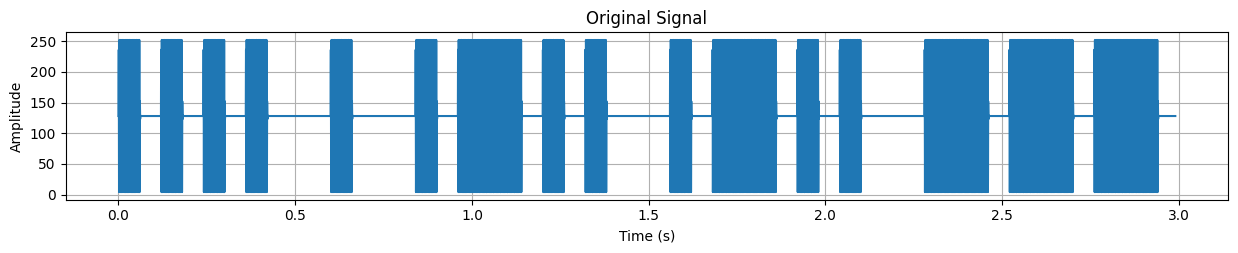

In [94]:
# plot original signal
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
plt.plot(t_axis, signal)
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

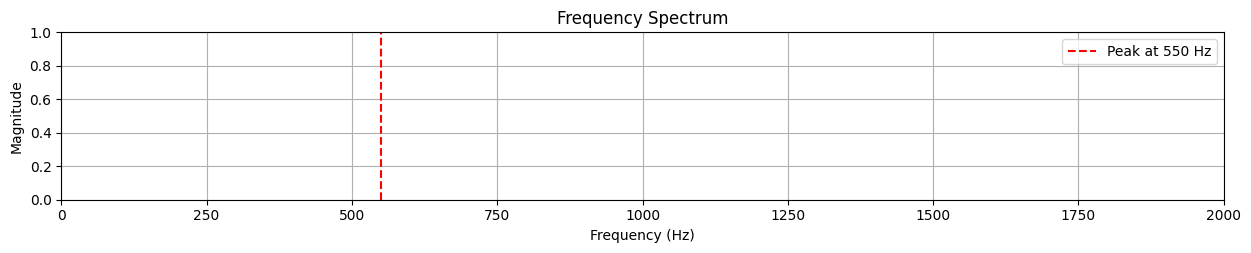

In [95]:
peak_freq, xf, yf = find_peak_frequency(signal, sample_rate)

plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
plt.axvline(peak_freq, color='r', linestyle='--', label=f'Peak at {peak_freq:.0f} Hz')
plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 2000)
plt.legend()
plt.grid(True)

Detected peak frequency: 549.83 Hz
Bandpass filter settings: low=449.83 Hz, high=649.83 Hz


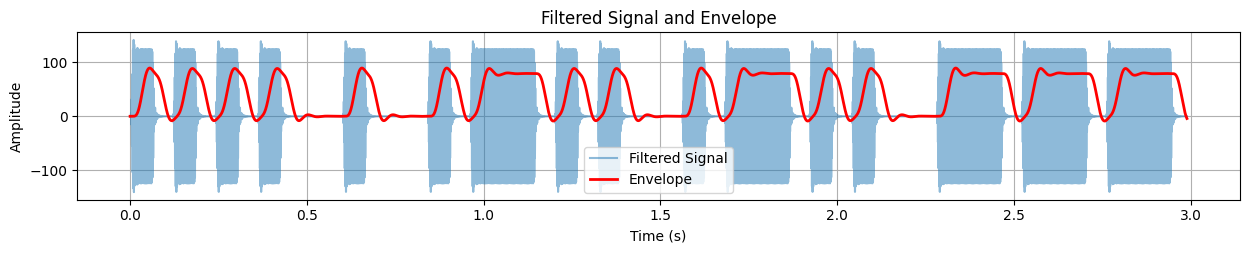

In [96]:
if peak_freq is not None:
    print(f'Detected peak frequency: {peak_freq:.2f} Hz')
    bandwidth = 200 # Hz
    low = peak_freq - (bandwidth / 2)
    high = peak_freq + (bandwidth / 2)
else:
    print(f'Could not detect peak frequency. Using default bandpass filter values')
    low, high = 650, 850
print(f'Bandpass filter settings: low={low:.2f} Hz, high={high:.2f} Hz')

filtered_signal = bandpass_filter(signal, low, high, sample_rate)
envelope = get_envelope(filtered_signal, sample_rate)

# plot filtered signal and envelope
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
plt.plot(t_axis, filtered_signal, label='Filtered Signal', alpha=0.5)
plt.plot(t_axis, envelope, label='Envelope', color='red', linewidth=2)
plt.title('Filtered Signal and Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

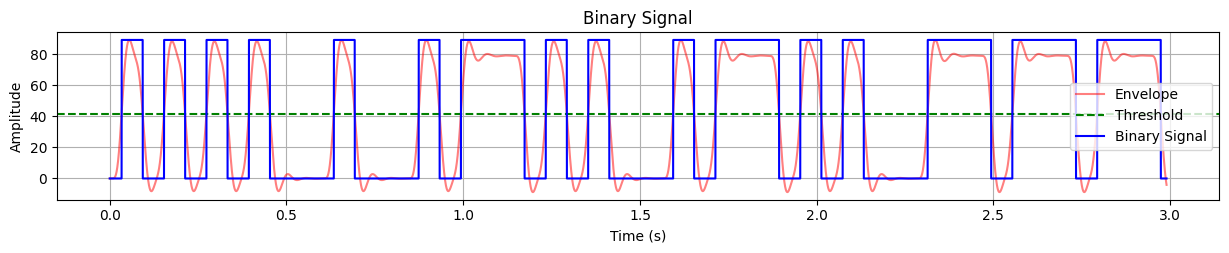

In [97]:
binary_signal, threshold = to_binary_signal(envelope)

# plot binary signal
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
plt.plot(t_axis, envelope, label='Envelope', color='red', alpha=0.5)
plt.axhline(threshold, color='green', linestyle='--', label='Threshold')
plt.plot(t_axis, binary_signal * np.max(envelope), label='Binary Signal', color='blue', linestyle='-')
plt.title('Binary Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

In [98]:
durations = measure_durations(binary_signal, sample_rate)
print('Measured durations sample')
for i, d in enumerate(durations[:20]):
    print(f'  {i+1}: State={d[0]}, Duration={d[1]:.3f}s')


Measured durations sample
  1: State=0, Duration=0.034s
  2: State=1, Duration=0.060s
  3: State=0, Duration=0.060s
  4: State=1, Duration=0.059s
  5: State=0, Duration=0.060s
  6: State=1, Duration=0.059s
  7: State=0, Duration=0.060s
  8: State=1, Duration=0.059s
  9: State=0, Duration=0.181s
  10: State=1, Duration=0.059s
  11: State=0, Duration=0.181s
  12: State=1, Duration=0.059s
  13: State=0, Duration=0.060s
  14: State=1, Duration=0.180s
  15: State=0, Duration=0.060s
  16: State=1, Duration=0.059s
  17: State=0, Duration=0.060s
  18: State=1, Duration=0.059s
  19: State=0, Duration=0.181s
  20: State=1, Duration=0.059s


In [99]:
decoded = decode_from_durations(durations)
print(f'Decoded: {decoded}')

Decoded: HELLO
